In [139]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from datetime import datetime
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
#from sklearn import svm
from sklearn.neural_network import MLPClassifier



config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with open('ks-projects-201612.csv', encoding="utf8", errors='ignore') as file:
    reader = csv.reader(file)
    data_set = list(reader)
data_set = np.array(data_set)

In [140]:
#utils
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

In [141]:
header = data_set[0]
data_set = data_set[1:len(data_set)] #data set without the header
print(header)

['ID ' 'name ' 'category ' 'main_category ' 'currency ' 'deadline '
 'goal ' 'launched ' 'pledged ' 'state ' 'backers ' 'country '
 'usd pledged ' '' '' '' '']


In [142]:
def clean_data_set(data_set):
    ti = time.time()
    delete_lines = []
    for i in range(len(data_set)):
        if isfloat(data_set[i, 6]) == False or data_set[i, 9] not in ['failed', 'successful']:
            delete_lines.append(i)
        elif float(data_set[i,6]) > 5000000 or float(data_set[i,6])< 20:
            delete_lines.append(i)
    data_set = np.delete(data_set, (delete_lines), axis=0)
    tf = time.time()
    print("temps : " + str(tf - ti))
    return data_set

data_set = clean_data_set(data_set)

temps : 5.0789313316345215


In [143]:
data_set_size = len(data_set)
data_set_size

280009

In [144]:
data_set_output = data_set[:,9]

In [145]:
list_of_output = []
for j in range(len(data_set_output)):
    if data_set_output[j] not in list_of_output:
        list_of_output.append(data_set_output[j])

list_of_output

['failed', 'successful']

In [146]:
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")
    d2 = datetime.strptime(d2, "%Y-%m-%d %H:%M:%S")
    return abs((d2 - d1).days)

In [147]:
import time
def build_input_layer(data_set):
    ti = time.time()
    input_data_set = np.zeros((len(data_set),5))
    for i in range (len(data_set)):
        if isfloat(data_set[i,6]):
            input_data_set[i,0] = days_between(data_set[i][7],data_set[i][5]) #time allowed to get the money
            input_data_set[i,1] = float(data_set[i][6]) #the goal
    labelencoder = LabelEncoder() 
    onehot_encoder = OneHotEncoder(sparse=False)
    
    #encode category
    input_data_set[:,2]=labelencoder.fit_transform(data_set[:,2])
    int_encoder = input_data_set[:,2].reshape(len(input_data_set[:,2]), 1)
    onehot_encoded_category = onehot_encoder.fit_transform(int_encoder)
  
    #encode main category
    input_data_set[:,3]=labelencoder.fit_transform(data_set[:,3])
    int_encoder = input_data_set[:,3].reshape(len(input_data_set[:,3]), 1)
    onehot_encoded_main_category = onehot_encoder.fit_transform(int_encoder)

    #encode country
    input_data_set[:,4]=labelencoder.fit_transform(data_set[:,4])
    int_encoder = input_data_set[:,4].reshape(len(input_data_set[:,4]), 1)
    onehot_encoded_country = onehot_encoder.fit_transform(int_encoder)
  
    input_data_set_one_hot_encoded = np.concatenate((np.reshape(input_data_set[:,0],(len(input_data_set[:,0]),1))
                                                     ,np.reshape(input_data_set[:,1],(len(input_data_set[:,1]),1)),
                                                   onehot_encoded_category ,onehot_encoded_main_category,onehot_encoded_country),axis=1)
    
    tf = time.time()
    print("temps : " +str(tf-ti))
    return input_data_set, input_data_set_one_hot_encoded

In [148]:
input_data, input_data_one_hot_encoded = build_input_layer(data_set)

/anaconda3/envs/env_tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/anaconda3/envs/env_tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "ca

temps : 14.011219024658203


23906.365383076976

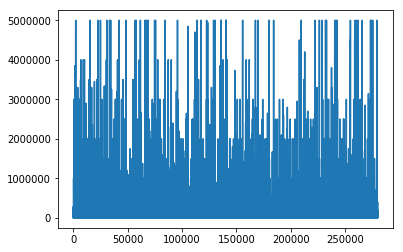

In [149]:
plt.plot(input_data[:,1])
np.mean(input_data[:,1])

In [150]:
#normalize the input_data
#max date time
max_date = max(input_data[:,0])
#max goal 
max_goal =max(input_data[:,1])
#max main categorie
max_categorie = max(input_data[:,2])
#max categorie
max_main_categorie = max(input_data[:,3])
#max country
max_country = max(input_data[:,3])
#max currency
#max_currency = max(input_data[:,5])

In [151]:
max_main_categorie

14.0

In [152]:
def normalize_input_data(input_data):
    input_data[:,0] = np.divide(input_data[:,0],max_date)#*100
    input_data[:,1] = np.divide(input_data[:,1],max_goal)#*100
    input_data[:,2] = np.divide(input_data[:,2],max_categorie)#*100
    input_data[:,3] = np.divide(input_data[:,3],max_main_categorie)
    input_data[:,4] = np.divide(input_data[:,3],max_country)#*100
    #input_data[:,5] = np.divide(input_data[:,5],max_currency)
    
    return input_data

input_data = normalize_input_data(input_data)

In [153]:
def normalize_input_data_one_hot(input_data):
    input_data[:,0] = np.divide(input_data[:,0],max_date)#*100
    input_data[:,1] = np.divide(input_data[:,1],max_goal)#*100
    return input_data
input_data_one_hot_encoded = normalize_input_data_one_hot(input_data_one_hot_encoded)

In [154]:
def build_target_layer(data_set):
    target_data = np.zeros(len(data_set))
    for i in range (len(data_set)):
        if data_set[i,9]=='failed':
            target_data[i] = 0
        else :
            target_data[i]= 1
    return target_data
target_data = build_target_layer(data_set)

In [155]:
print (len(target_data))
print (len(input_data))
np.mean(input_data[:,1])

280009
280009


0.0047812730766153945

In [156]:
train_data_set_size = 200000
test_data_set_size = 50000
train_input_data = input_data[0:train_data_set_size]
test_input_data = input_data[train_data_set_size + 1 : train_data_set_size + test_data_set_size]

train_target_data = target_data[0:train_data_set_size]
test_target_data = target_data[train_data_set_size + 1 : train_data_set_size + test_data_set_size]

In [157]:
train_input_data_one_hot_encoded = input_data_one_hot_encoded[0:train_data_set_size]
test_input_data_one_hot_encoded = input_data_one_hot_encoded[train_data_set_size + 1 : train_data_set_size + test_data_set_size]

Logistic regression and random forest with label encoded : 

In [158]:
log_reg = LogisticRegression()
log_reg.fit(train_input_data,train_target_data)
print(str(log_reg.score(test_input_data,test_target_data)*100) + " %")

/anaconda3/envs/env_tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


60.80121602432048 %


In [159]:
rdf = RandomForestClassifier(n_estimators=200)
rdf.fit(train_input_data,train_target_data)
print(str(rdf.score(test_input_data,test_target_data)*100) + " %")

64.56929138582773 %


In [160]:
activation='relu', alpha=1e-05, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False,
              epsilon=1e-08, hidden_layer_sizes=(5, 2),
              learning_rate='constant', learning_rate_init=0.001,
              max_iter=200, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=1,
              shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

IndentationError: unexpected indent (<ipython-input-160-3cbfabad63c2>, line 2)

In [161]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-05,
                     hidden_layer_sizes=(30, 10), random_state=1, learning_rate_init=0.1)
clf.fit(train_input_data, train_target_data)
print(str(clf.score(test_input_data,test_target_data)*100) + " %")

61.8392367847357 %


In [74]:
#clf = svm.SVC(gamma='scale')
#clf.fit(train_input_data,train_target_data)
#print(str(clf.score(test_input_data,test_target_data)*100) + " %")
67.26334526690533

Logistic regression and random forest with one hot encoded vectors :

In [162]:
log_reg = LogisticRegression()
log_reg.fit(train_input_data_one_hot_encoded,train_target_data)
print("Accuracy with logistic regression " + str(log_reg.score(test_input_data_one_hot_encoded,test_target_data)*100) + " %")

/anaconda3/envs/env_tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy with logistic regression 66.47532950659013 %


In [164]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-05,
                     hidden_layer_sizes=(30, 10), random_state=1)
clf.fit(train_input_data_one_hot_encoded, train_target_data)  
print(str(clf.score(test_input_data_one_hot_encoded,test_target_data)*100) + " %")

66.85333706674133 %


In [78]:
rdf = RandomForestClassifier(n_estimators=300)
rdf.fit(train_input_data_one_hot_encoded,train_target_data)
print("Accuracy with random forest "+ str(rdf.score(test_input_data_one_hot_encoded,test_target_data)*100) + " %")

KeyboardInterrupt: 